In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Classification

### Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from datetime import datetime
from copy import deepcopy
import torch
from torch.utils.data import Dataset
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.models import ResNet18_Weights
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score

### Loading dataset

In [ ]:
data_folder = '/content/drive/MyDrive/02740/02740 final project /size_1024'

In [ ]:
import os

os.listdir(data_folder)

In [ ]:
classes_filepaths = {
    0: [],
    1: [],
    2: [],
    3: []
}

for folder in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder)
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    if 'PD' in folder:
        classes_filepaths[0].extend(files)
    elif 'PR-' in folder:
        classes_filepaths[1].extend(files)
    elif 'CR' in folder:
        classes_filepaths[2].extend(files)
    else:
        classes_filepaths[3].extend(files)

for i in classes_filepaths:
    print(i, len(classes_filepaths[i]))


0 877
1 646
2 747
3 445


### Datasets

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os


class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): List of image file paths.
            labels (list): List of corresponding image labels.
            transform (callable, optional): Optional transform to be applied
                                            on a sample.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open the image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

In [ ]:
def split_dataset(dataset_dict, test_size=0.2, val_size=0.2, random_seed=42):
    # Step 1: Create lists for image paths and labels
    image_paths = []
    labels = []

    for label, filenames in dataset_dict.items():
        for filename in filenames:
            image_paths.append(filename)
            labels.append(label)

    # Step 2: Split data into training + validation and test datasets
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        image_paths, labels, test_size=test_size, stratify=labels, random_state=random_seed)

    # Step 3: Split the remaining training+validation into train and validation datasets
    val_size_adjusted = val_size / (1 - test_size)  # Adjust for the train + val split
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels, test_size=val_size_adjusted, stratify=train_val_labels, random_state=random_seed)

    # Step 4: Create PyTorch datasets for each split
    # Define transforms (for example, resizing and normalization)
    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = CustomImageDataset(train_paths, train_labels, transform=transform)
    val_dataset = CustomImageDataset(val_paths, val_labels, transform=transform)
    test_dataset = CustomImageDataset(test_paths, test_labels, transform=transform)

    return train_dataset, val_dataset, test_dataset

### UNet

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

class UNetForClassification(nn.Module):
    def __init__(self, num_classes):
        super(UNetForClassification, self).__init__()
        self.unet = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=2) # 2 means 4: 00, 01, 10, 11

        self.encoder = self.unet.encoder
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(self.encoder.out_channels[-1], num_classes)

    def forward(self, x):
        features = self.unet.encoder(x)
        pooled = self.global_pool(features[-1])
        pooled = torch.flatten(pooled, 1)
        out = self.fc(pooled)
        return out


### Training

In [ ]:
# Split the dataset
train_dataset, val_dataset, test_dataset = split_dataset(classes_filepaths)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
num_classes = 4
model = UNetForClassification(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda


In [ ]:
from tqdm import tqdm

def train_model(
        num_epochs,
        model,
        criterion,
        device,
        optimizer,
        train_dataloader,
        valid_dataloader,
        curr_best_val_acc=0
):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    curr_best_val_acc = curr_best_val_acc
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_model = model

    for epoch in range(num_epochs):
        model.train()
        curr_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in tqdm(train_dataloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            curr_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        curr_train_loss /= len(train_dataloader)
        train_losses.append(curr_train_loss)
        train_accuracies.append(correct_train / total_train)

        model.eval()
        curr_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in tqdm(valid_dataloader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                curr_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

            curr_val_loss /= len(valid_dataloader)
            val_losses.append(curr_val_loss)
            val_accuracies.append(correct_val / total_val)

        if val_accuracies[-1] > curr_best_val_acc:
            curr_best_val_acc = val_accuracies[-1]
            best_model = deepcopy(model)
            torch.save(model.state_dict(), f'unet_{timestamp}_{curr_best_val_acc}.pth')

        print(f"[{epoch+1}]/[{num_epochs}] --- Train loss : {curr_train_loss} --- Val loss : {curr_val_loss}")
        print(f"[{epoch+1}]/[{num_epochs}] --- Train acc : {train_accuracies[-1]} --- Val acc : {val_accuracies[-1]}")

    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    10,
    model,
    criterion,
    device,
    optimizer,
    train_loader,
    val_loader
)

In [ ]:
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss curves")
plt.legend()
plt.grid(1)
plt.show()


plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curves")
plt.legend()
plt.grid(1)
plt.show()

### Evaluation

In [ ]:
best_model.to(device)
best_model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

100%|██████████| 34/34 [00:22<00:00,  1.49it/s]

Test Accuracy: 87.66%
Confusion Matrix:
[[149  10  12   5]
 [ 12 109   2   6]
 [  9   5 135   0]
 [  5   0   1  83]]


In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds)


In [ ]:
classes = ['PD', 'PR', 'CR', 'HLTHY']
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, class_name in enumerate(classes):
    print(f"Accuracy for class {class_name}: {class_accuracies[i] * 100:.2f}%")

Accuracy for class PD: 84.66%
Accuracy for class PR: 84.50%
Accuracy for class CR: 90.60%
Accuracy for class HLTHY: 93.26%


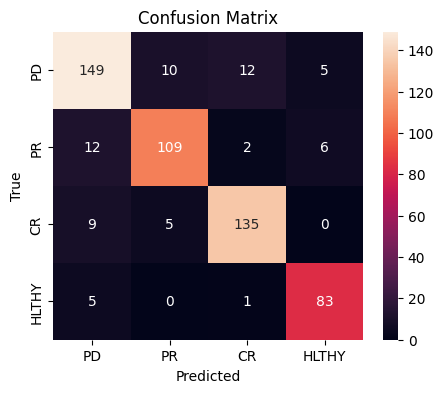

In [ ]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

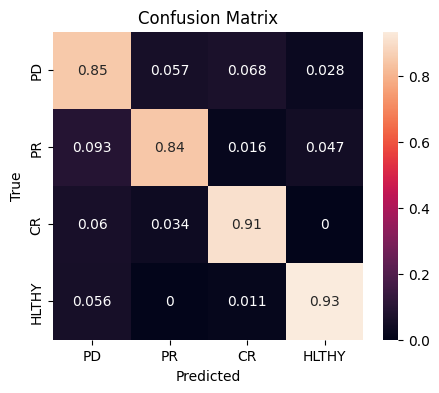

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds, normalize='true')
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

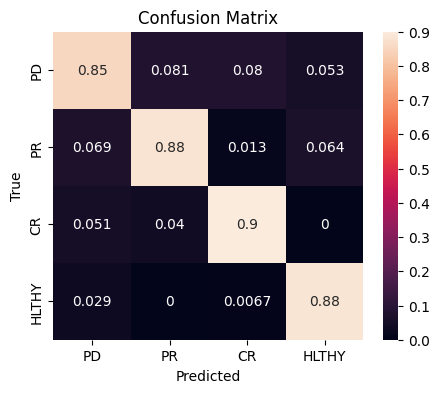

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds, normalize='pred')
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Explainability